First might be a good idea to get an idea of what stocks are good pairs.
Want to get high correlation in terms of returns

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import yfinance as yf
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
sns.set_style('darkgrid')

In [130]:
ticker = 'AAPL'
start = '2000-01-01'
end = '2023-12-17'

In [131]:
df = yf.download(ticker, start,end)

[*********************100%***********************]  1 of 1 completed


In [132]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.846127,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.774790,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.786128,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.718098,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.752113,460734400
...,...,...,...,...,...,...
2023-12-11,193.110001,193.490005,191.419998,193.179993,192.933807,60943700
2023-12-12,193.080002,194.720001,191.720001,194.710007,194.461868,52696900
2023-12-13,195.089996,198.000000,194.850006,197.960007,197.707718,70404200


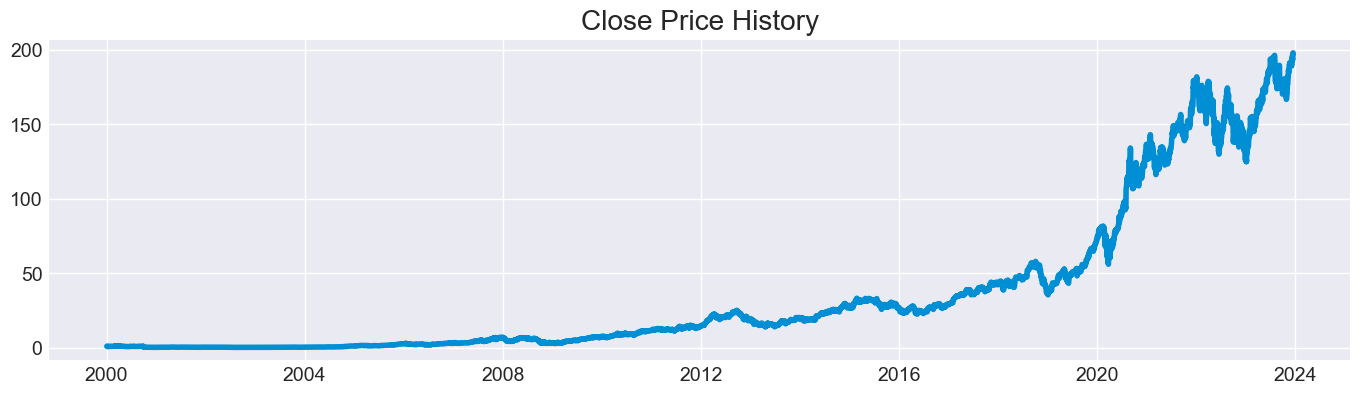

In [133]:
plt.figure(figsize = (15,4))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.show()

In [134]:
data = df.filter(['Close'])


In [135]:
len(data)

6028

In [136]:
#Converts data into numpy array
#dataset = data.value

#Split data
#training_data_len = math.ceil(len(dataset)*.8)
test_len = int(len(data) * 0.8)
    
test_len

4822

In [137]:
#Scale the data

scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.00386685],
       [0.00344101],
       [0.00350869],
       ...,
       [0.99924198],
       [1.        ],
       [0.99727105]])

### Training dataset

In [153]:
lookback = 60

In [154]:
train_data = scaled_data[0:test_len,:]

x_train = []
y_train = []

#going to use the past 60 timesteps to predict next step
for i in range(lookback, len(train_data)):
    x_train.append(train_data[i-lookback:i,0])
    y_train.append(train_data[i,0])

In [139]:
#convert two train to np arrays for LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

In [140]:
# LSTM needs 3 dimensions --> samples, timesteps, features
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1   ))
x_train.shape

(4762, 60, 1)

In [141]:
model = Sequential()
model.add(LSTM(50,return_sequences = True, input_shape =(x_train.shape[1],1 )))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [142]:
#compile the model
model.compile( optimizer ='adam', loss = 'mean_squared_error',metrics =['accuracy'])

In [143]:
model.fit(x_train,y_train, batch_size =1, epochs = 2 )

Epoch 1/2
4762/4762 [==============================] - 190s 39ms/step - loss: 8.1651e-05 - accuracy: 2.1000e-04
Epoch 2/2
4762/4762 [==============================] - 184s 39ms/step - loss: 5.1348e-05 - accuracy: 2.1000e-04


### Testing dataset

In [155]:
test_data = scaled_data[test_len-lookback:,:]

x_test = []
y_test = data.iloc[test_len:,:]

for i in range(lookback, len(test_data)):
    x_test.append(test_data[i-lookback:i, 0])


In [145]:
x_test = np.array(x_test)

In [146]:
# reshape for use of LSTM Model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [147]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

38/38 [==============================] - 2s 20ms/step


In [148]:
#Get RMSE --> give us an indication of fit
rmse = np.sqrt(  np.mean(( (predictions - y_test)**2) )  )
rmse

C:\Users\caimi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Close    6.847584
dtype: float64

<ipython-input-149-5d62e655cd2c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


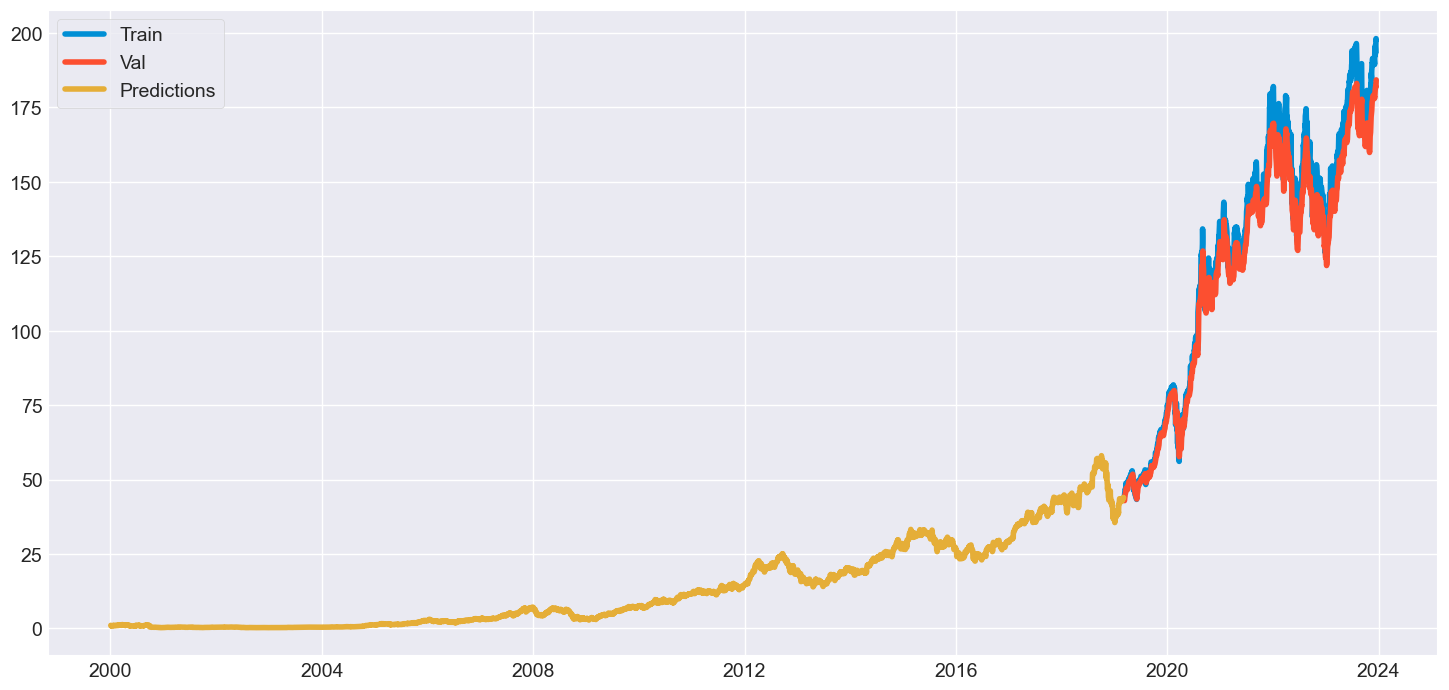

In [149]:
#plot the data
train = data[:test_len]
valid = data[test_len:]
valid['Predictions'] = predictions

plt.figure(figsize = (16,8))
plt.plot(valid[['Close','Predictions']])
plt.plot(train['Close'])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [150]:
valid

,Close,Predictions
Date,,
2019-03-06,43.630001,43.330181
2019-03-07,43.125000,43.294987
2019-03-08,43.227501,43.072910
2019-03-11,44.724998,42.902748
2019-03-12,45.227501,43.286526
...,...,...
2023-12-11,193.179993,182.032196
2023-12-12,194.710007,181.798050
2023-12-13,197.960007,181.918854


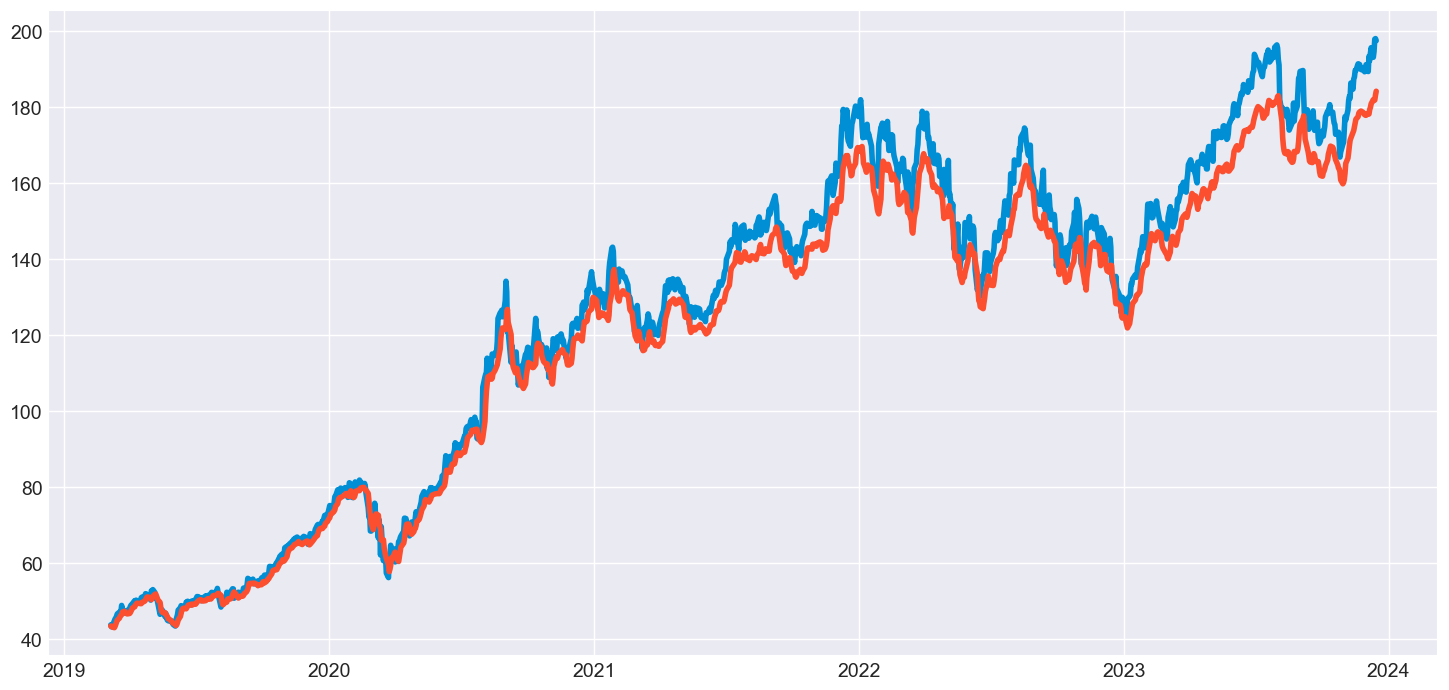

In [151]:
plt.figure(figsize = (16,8))

plt.plot(valid[['Close','Predictions']])

plt.show()